# Bayes - A Nonparametric Bayesian Approach to Modeling Overlapping Clusters

In [214]:
%matplotlib inline

In [250]:
from matplotlib.pyplot import figure, show
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal 

## Infinite Overlapping Mixture Model with Gaussian clusters

In [216]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)
df = pd.DataFrame(X, columns=['X1', 'X2'])
df['y']=y
df.head()

,X1,X2,y
0,-0.807236,2.669463,2
1,1.926358,4.152430,0
2,-1.500166,3.101333,2
3,-1.109050,2.877864,2
4,-2.531227,1.919691,2


In [217]:
#Initialiser le centre des clusters (Facultatif)
clr = KMeans(n_clusters=3)
clr.fit(X,y)
clr.score(X)
clr.cluster_centers_[1].reshape(2,1)

array([[ 0.94726224],
       [ 4.29657893]])

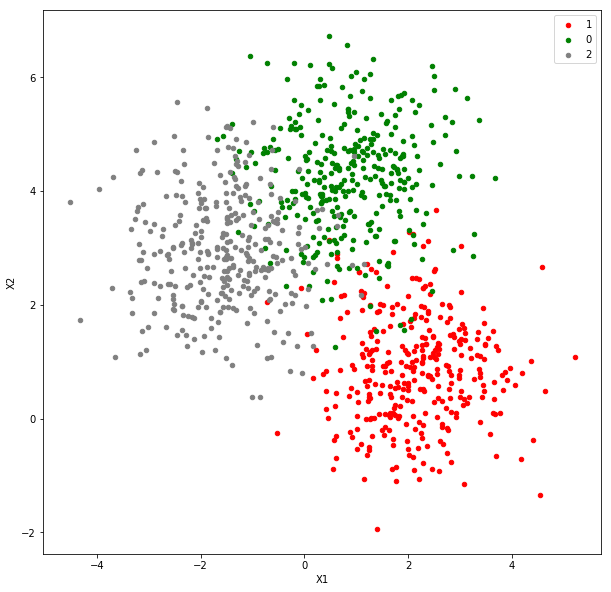

In [249]:
ax = df[y==1].plot(x="X1", y="X2", kind="scatter", label="1", color='r', figsize=(10,10))
df[y==0].plot(x="X1", y="X2", kind="scatter", label="0",color='green', ax=ax)
df[y==2].plot(x="X1", y="X2", kind="scatter", label="2",color='grey', ax=ax)

In [252]:
#Je recupere les "overlapping clusters" avec les kNearestNeighbor
#Si la probailité d'être dans le cluster k est d'au moins 0.1 (à tuner) alors l'observation appartient au cluster k
knn =  KNeighborsClassifier(n_neighbors=30)
knn.fit(X,y)
pred = knn.predict_proba(X)
pred

array([[ 0.06666667,  0.        ,  0.93333333],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.03333333,  0.        ,  0.96666667],
       ..., 
       [ 0.03333333,  0.86666667,  0.1       ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.06666667,  0.93333333,  0.        ]])

In [222]:
#Real clusters matrix
def possible_clusters(X):
    I=X.shape[0]
    J=X.shape[1]
    result = np.zeros(X.shape)
    for i in range(I):
        for j in range(J):
            if X[i,j]>0.1:
                result[i,j]=1
    return result
    
#Z = pd.get_dummies(y).as_matrix()
Z=possible_clusters(pred)
Z

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

## Figure 3 algorithm
###  1. Initialize $\Theta$

In [224]:
#TODO : Meilleure initialisation de theta
mu= [
    clr.cluster_centers_[0].reshape(2,1),
    clr.cluster_centers_[1].reshape(2,1),
    clr.cluster_centers_[2].reshape(2,1)
]
sigma=[
    np.matrix([[1, 0], [0, 1]]),
    np.matrix([[1, 0], [0, 1]]),
    np.matrix([[1, 0], [0, 1]])
]

###  2. Initialize other elements

In [225]:
NumIters = 100
N = df.shape[0]
Z_hat = np.zeros((N,3))
PZ_hat = np.zeros((N,3))
K=3

In [229]:
#On prend les n premieres observations et on leur donne les bons clusters associés pour entrainer le modele
n=100
for i in range(n):
    Z_hat[i,]=Z[i,]
#Z_hat

###  3. Run algorithm

In [230]:
def m_without_i_k(Z, i, k):
    result=0
    for j in range(Z_hat.shape[0]):
        if j!=i:
            result+= Z_hat[j,k]
    return result

for j in range(NumIters):
    for i in range(0,N):
        k_plus = [] #k+ is the number of clusters which data points, excluding i, belong to
        for k_ in range(K):
            if Z_hat[i,k_] == 0:
                k_plus.append(k_)
        for k in k_plus:
            if Z_hat[i,k] == 0:
                #z_ik ⇠ zik|z−i,k, xi,theta
                sum_zi_sigma = np.matrix([[0, 0], [0, 0]])
                sum_zi_sigma_mu = np.matrix([[0], [0]])
                Z_hat[i,k] = 1
                for k_ in range(K):
                    temp=np.dot(Z_hat[i,k_],np.linalg.inv(sigma[k_]))
                    sum_zi_sigma=sum_zi_sigma+temp
                    sum_zi_sigma_mu=sum_zi_sigma_mu+np.dot(temp,mu[k_])
                #print(type(sum_zi_sigma_mu))
                S=np.linalg.inv(sum_zi_sigma)
                m=(np.dot(S,sum_zi_sigma_mu)).flatten().tolist()[0]
                #print(sum_zi_sigma)
                PZ_hat[i,k] = (m_without_i_k(Z_hat, i, k)/N)*multivariate_normal.pdf(X[i,], mean =m, cov=S)
                Z_hat[i,k] = 0
        #Propose adding new clusters 
        #Accept or reject proposal
        for k in k_plus:
            if Z_hat[i,k] == 0:
                u = np.random.uniform(0,1,1)
                if u[0]<PZ_hat[i,k]:
                    Z_hat[i,k]=1
                    print(i,k)
    #Resample theta|Z,X using MH proposal
    #for k in range(K):
        

107 2
129 2
302 0
420 1
487 0
688 2
198 0
365 2
382 2
397 2
696 0
239 2
341 2
462 1
763 2
938 0
222 2
386 1
665 2
873 0
998 2
178 1
329 0
431 2
436 2
479 2
570 2
235 0
429 2
481 2
891 1
928 2
458 2
476 1
679 0
715 1
746 2
928 1
954 0
994 2
396 0
397 1
569 2
590 2
594 0
687 2
77 2
162 1
193 2
437 2
873 2
886 2
940 1
956 0
553 2
634 0
655 0
668 2
856 2
308 1
313 1
382 1
547 2
561 0
614 0
616 1
794 2
967 0
993 1
161 1
336 1
383 0
399 0
492 2
515 1
663 0
736 1
929 0
951 2
283 0
385 2
472 0
493 1
517 2
575 0
587 2
699 2
716 2
807 1
30 1
106 2
224 1
316 2
425 0
518 1
525 0
620 2
783 2
817 1
937 0
238 2
307 1
346 0
406 1
408 0
537 0
573 2
577 0
876 0
83 2
361 2
369 0
387 0
403 1
478 2
585 1
597 2
311 1
325 1
491 1
518 0
534 2
615 0
802 2
215 2
222 0
453 0
598 2
874 2
882 2
217 2
275 2
664 0
799 2
822 1
845 2
942 0
267 2
332 2
478 0
570 0
584 2
598 1
729 1
754 0
960 2
321 0
340 2
430 2
519 2
550 2
647 2
673 1
822 2
44 0
173 2
236 2
338 2
620 1
700 1
989 0
168 0
289 2
352 2
605 2
652 2
766 2
81

In [ ]:
alpha = 10
from scipy.stats import poisson

def get_cluster_center(clr_model, n):
    mu = [clr.cluster_centers_[i].reshape(2,1) for i in range(0,n,1)]
    return mu

def get_sigma(n):
    sigma=[np.matrix([[1, 0], [0, 1]]) for i in range(n)]
    return sigma
    
def get_index_vect(vect, thr):
    vect_index = []
    for i in range(len(vect)):
        if vect[i]<=thr:
            vect_index.append(i)
    return vect_index

for j in range(NumIters):
    for i in range(0,N):
        k_plus = [] #k+ is the number of clusters which data points, excluding i, belong to
        for k_ in range(K):
            if Z_hat[i,k_] == 0:
                k_plus.append(k_)
        for k in k_plus:
            if Z_hat[i,k] == 0:
                #z_ik ⇠ zik|z−i,k, xi,theta
                sum_zi_sigma = np.matrix([[0, 0], [0, 0]])
                sum_zi_sigma_mu = np.matrix([[0], [0]])
                Z_hat[i,k] = 1
                for k_ in range(K):
                    temp=np.dot(Z_hat[i,k_],np.linalg.inv(sigma[k_]))
                    sum_zi_sigma=sum_zi_sigma+temp
                    sum_zi_sigma_mu=sum_zi_sigma_mu+np.dot(temp,mu[k_])
                #print(type(sum_zi_sigma_mu))
                S=np.linalg.inv(sum_zi_sigma)
                m=(np.dot(S,sum_zi_sigma_mu)).flatten().tolist()[0]
                #print(sum_zi_sigma)               
                PZ_hat[i,k] = (m_without_i_k(Z_hat, i, k)/N)*multivariate_normal.pdf(X[i,], mean =m, cov=S)
                Z_hat[i,k]=0
                
                u = np.random.uniform(0,1,1)
                if u[0]<PZ_hat[i,k]:
                    Z_hat[i,k]=1
                    print(i,k)
        #Propose adding new clusters 
        
        if i!=0:
            k_new = poisson.rvs(alpha/i)
            if k_new>0:
                K=K+k_new
                Z_new = np.zeros((N,k_new))
                PZ_hat = np.concatenate((PZ_hat, Z_new), axis=1)
                Z_new[i,] = 1
                Z_hat = np.concatenate((Z_hat, Z_new), axis=1)                
                clr = KMeans(n_clusters=K)
                clr.fit(X,y)
                mu = get_cluster_center(clr, K)
                sigma = get_sigma(K)
        #Accept or reject proposal
    
    print(j)
    k_old = get_index_vect(sum(Z_hat), 1)
    if len(k_old)>0:
        Z_hat = np.delete(Z_hat, k_old, 1)
        PZ_hat = np.delete(PZ_hat , k_old, 1)
        K=K-len(k_old)
                
    #Resample theta|Z,X using MH proposal
    #for k in range(K):

In [231]:
U = np.dot(Z,Z.T)
print(U)
U_hat = np.dot(Z_hat,Z_hat.T)
print(U_hat)

[[ 1.  0.  1. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]]
[[ 3.  1.  1. ...,  0.  1.  3.]
 [ 1.  1.  0. ...,  0.  0.  1.]
 [ 1.  0.  1. ...,  0.  1.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  1.  1.]
 [ 3.  1.  1. ...,  0.  1.  3.]]


### 4. $U$ and $\hat{U}$ comparison

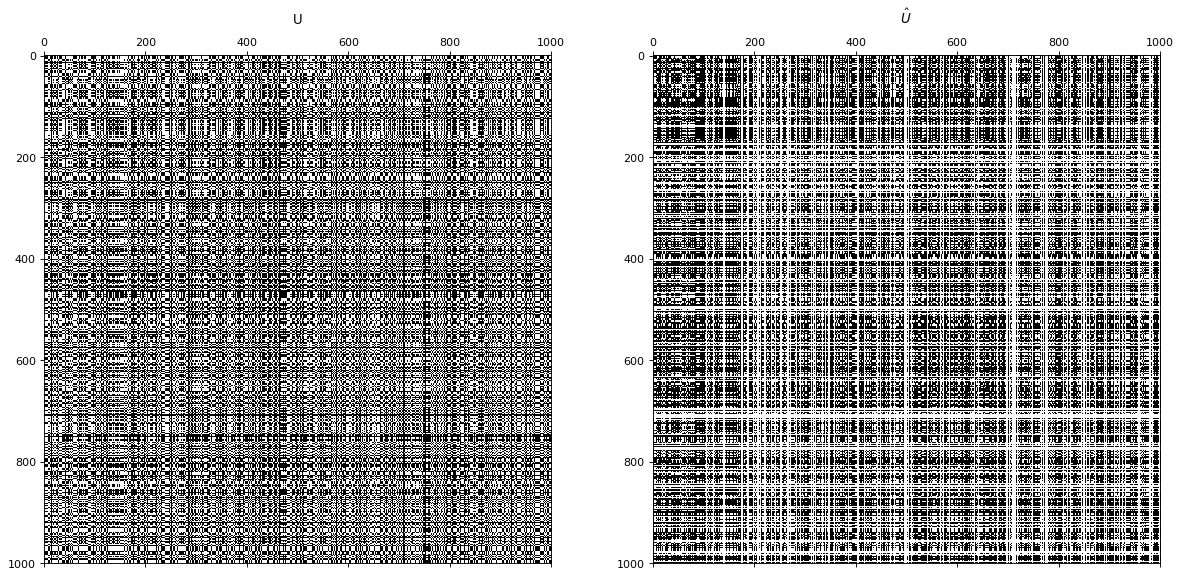

In [257]:
fig = figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('U')
ax2.title.set_text('$\hat{U}$')

ax1.spy(U)
ax2.spy(U_hat)

show()